In [55]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

import pickle

In [2]:
users_df=pd.read_csv("../data/users_processing_vModel.csv")

In [3]:
# Split the data into train, validation, and test sets
train, test = train_test_split(users_df, test_size=0.2, random_state=42)

# For the training set
X_train = train.drop(columns=['F_Grade'])
y_train = train['F_Grade']

# For the testing set
X_test = test.drop(columns=['F_Grade'])
y_test = test['F_Grade']

# Models

Once our data has been processed is time to train a model. Our idea is to train all possible modes, looking for the best hyperparameters for each one, and then make an ensemble technique with the best ones. 

To asses validation we will use Root Mean Squared Logarithmic Error (RMSLE), as our problem is a regression one, with a wide range of values for the price of a house.

In [4]:
# We will perform Grid Search to find the best hyperparameters for our models, and to assess scoring, we create this function

# Function to calculate the Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):

    """
    Parameters:
    - y_true: True values (actuals).
    - y_pred: Predicted values.

    Returns:
    - RMSLE score (negative, as it is used as a loss function).

    General Explanation:
    RMSLE is a metric commonly used for evaluating predictive models when the target variable is a positive quantity
    with a wide range of values.
    It is preferred over metrics like MSE or RMSE because it is sensitive to the magnitude of values.
    For example, predicting 600 for a real value of 1000 has an error of 400, and predicting 6000 for a real value of 10000 has an error of 4000.
    While it might seem that an error of 400 is better than 4000, but this is not a case because the relative deviation in both cases is same.
    RMSLE accounts for the relative deviation rather than absolute values. RMSLE provide us a more meaningful measure.

    Usage:
    - Call this function to calculate RMSLE between true and predicted values.

    Important Note:
    - The negative sign is intentional. Scikit-learn optimization algorithms seek to maximize the scoring function,
      so returning a negative value aligns with the goal of minimizing RMSLE.

    Scikit-Learn Integration:
    - This function can be used as a scoring metric in scikit-learn. For example, when performing grid search,
      you can use 'make_scorer(rmsle)' to create a scorer suitable for optimization.
    """

    # Convert y_true to a NumPy array
    a = y_true.values
    
    # Check that the lengths of y_true and y_pred are the same
    assert len(a) == len(y_pred)
    
    # Calculate RMSLE using the logarithmic transformation
    rmsle = np.sqrt(np.mean((np.log1p(abs(a)) - np.log1p(abs(y_pred)))**2))
    
    # Return the negative value of RMSLE (for minimization during grid search)
    return -rmsle

# Create a scorer using make_scorer
rmsle_score = make_scorer(rmsle)

In [5]:
# We create a dictionary to save the models and their error to later compare them

trained_models={}

In [6]:
# We create a function to perform predictions and get the error of the prediction

def predictions(model, X, y, dataset='Training'):

    """
    Parameters:
    - model: The predictive model.
    - X: Input features.
    - y: True values (actuals).
    - dataset: The dataset for which predictions are made ('Training' or 'Testing').

    Returns:
    - RMSLE score.

    General Explanation:
    This function facilitates the prediction process using a given model and computes the RMSLE as a metric to
    evaluate the model's performance. RMSLE is particularly useful for regression tasks involving positive quantities
    with a wide range of values.

    Usage:
    - Call this function with the trained model, input features (X), and true values (y) to obtain predictions
      and calculate RMSLE.
    """

    # If dataset is 'Training', perform cross-validated predictions using cross_val_predict
    if dataset == 'Training':
        y_model_pred = cross_val_predict(model, X, y, cv=5)
    else:
        # If dataset is not 'Training', use the model to predict directly
        y_model_pred = model.predict(X)

    # Calculate the Root Mean Squared Logarithmic Error (RMSLE) using mean_squared_error
    rmsle = mean_squared_error(np.log1p(abs(y)), np.log1p(abs(y_model_pred)), squared=False)
    
    # Print the RMSLE for the specified dataset
    print(f"Root Mean Squared Logarithmic Error on {dataset}: {rmsle}")
    
    # Return the calculated RMSLE
    return rmsle

In [7]:
# We define a function to calculate predictions and errors in the training dataset and add the model to the dictionary

def predict_and_save(model, name):

    """
    Parameters:
    - model: The predictive model.
    - name: A descriptive name for the model, used as a key in the dictionary.

    Returns:
    - None.

    General Explanation:
    This function facilitates the process of performing predictions on the training dataset using a given model.
    It then calculates the training RMSLE and adds the model along with its training RMSLE to a dictionary.

    Usage:
    - Call this function with the trained model and a descriptive name to store the model's information.
    """
    
    # Perform predictions on the training dataset and calculate the training RMSLE
    train_rmsle = predictions(model, X_train, y_train)

    # Add the model and its training RMSLE to the dictionary
    trained_models[name] = (model, train_rmsle)

In [8]:
# We define a function to apply grid search in a given model and return the best estimator

def apply_grid_search(model, param_grid, random=False):

    """    Parameters:
    - model: The predictive model.
    - param_grid: Dictionary specifying the hyperparameter grid for search.
    - random: Boolean flag indicating whether to use RandomizedSearchCV (True) or GridSearchCV (False).

    Returns:
    - The best estimator (model with the best hyperparameters).

    General Explanation:
    This function performs grid search or randomized search to find the best hyperparameters for a given model.
    The search is conducted over the specified hyperparameter grid, and the best estimator (model with the optimal hyperparameters)
    is returned.

    Usage:
    - Call this function with the model, hyperparameter grid, and an optional flag to specify randomized search.
    """
    
    # Initialize a grid search object (either GridSearchCV or RandomizedSearchCV based on the 'random' parameter)
    grid_search = None
    if random:
        grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring=rmsle_score, random_state=42)
    else:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_score, verbose=0)
        
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters found during the search
    print("Best Parameters:", grid_search.best_params_)

    # Return the best estimator (model with the best hyperparameters)
    return grid_search.best_estimator_
    
        

Before start training, to clarify that we won't split the training data into training and validation sets, as we will perform grid search to find the best hyperparameter for our models, which implies cross validation. To perform grid search we will be using the methods `GridSearchCV()`, for the models with low hyperparameter time complexity, and `RandomizedSearchCV()` for the models with high hyperparameter time complexity.

## Linear regression with regularitzation

In [9]:
## Ridge

# Define the parameter grid for Ridge and Lasso Regression
param_grid = {'alpha': [10, 20, 50, 70, 90, 100]}

ridge_model=apply_grid_search(Ridge(random_state=42), param_grid)


Best Parameters: {'alpha': 10}


In [10]:
predict_and_save(ridge_model, 'ridge')

Root Mean Squared Logarithmic Error on Training: 0.5190293570517206


In [11]:
## Lasso

lasso_model = apply_grid_search(Lasso(random_state=42), param_grid)

Best Parameters: {'alpha': 10}


In [12]:
predict_and_save(lasso_model, 'lasso')

Root Mean Squared Logarithmic Error on Training: 0.6050762536686594


## Random Forest

In this model, and in gradient boosting and extreme gradient boosting, we will use `RandomizedSearchCV()` instead of `GridSearchCV()`, since its time complexity is very high. As a downside not always will be selected the best parameters, and to solve this we will save in a variable the best parameters we have found until now, and then compare them with the ones found in the current iteration, to select the ones which gives the better result.

In [13]:
## Random Forest

param_grid = {
    'n_estimators': [10, 50, 90, 100, 110],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':['sqrt'],
}

rf_model_temp=apply_grid_search(RandomForestRegressor(random_state=42), param_grid, random=True)



Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [14]:
# Comparison between the best parameters found and the current parameters found

best_params_until_now={'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

rf_model_temp2=RandomForestRegressor(**best_params_until_now)

if(predictions(rf_model_temp, X_train, y_train) > predictions(rf_model_temp2, X_train, y_train)):
    rf_model=rf_model_temp2
    rf_model.fit(X_train, y_train)
else: 
    rf_model=rf_model_temp

Root Mean Squared Logarithmic Error on Training: 0.40154763239013663
Root Mean Squared Logarithmic Error on Training: 0.39552869250497996


In [15]:
predict_and_save(rf_model, 'random forest')

Root Mean Squared Logarithmic Error on Training: 0.403776097878541


## Support Vector Machines

In [16]:
## SVM

# Define the parameter grid to search
param_grid_linear = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5]
}

param_grid_poly = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'degree': [2, 3, 4]  # Specify the degree of the polynomial kernel
}

param_grid_rbf_sigmoid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'gamma': [0.01, 0.1, 1] # Specify the gamma parameter for the RBF kernel
}


linear_svr_model=apply_grid_search(SVR(kernel='linear'), param_grid_linear)
polynomial_svr_model=apply_grid_search(SVR(kernel='poly'), param_grid_poly)
rbf_svr_model=apply_grid_search(SVR(kernel='rbf'), param_grid_rbf_sigmoid)
sigmoid_svr_model=apply_grid_search(SVR(kernel='sigmoid'), param_grid_rbf_sigmoid)

Best Parameters: {'C': 1, 'epsilon': 0.2}
Best Parameters: {'C': 0.1, 'degree': 4, 'epsilon': 0.1}
Best Parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 0.01}
Best Parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 0.01}


In [17]:
print('linear svm:')
predict_and_save(linear_svr_model, 'linear svm')
print('polynomial svm:')
predict_and_save(polynomial_svr_model, 'polynomial svm')
print('rbf svm:')
predict_and_save(rbf_svr_model, 'rbf svm')
print('sigmoid svm:')
predict_and_save(sigmoid_svr_model, 'sigmoid svm')

linear svm:
Root Mean Squared Logarithmic Error on Training: 0.47199836488651725
polynomial svm:
Root Mean Squared Logarithmic Error on Training: 0.5434180775807282
rbf svm:
Root Mean Squared Logarithmic Error on Training: 0.40611275413326786
sigmoid svm:
Root Mean Squared Logarithmic Error on Training: 0.5494729386266882


## Gradient Boosting

In [21]:
## Gradient Boosting

gtb_model = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [500, 600, 700],
    'max_depth':[3, 4, 5],
    'learning_rate':[0.01, 0.015, 0.1],
}

gtb_model_temp=apply_grid_search(GradientBoostingRegressor(), param_grid, random=True)

Best Parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1}


In [22]:
# Comparison between the best parameters found and the current parameters found

best_params_until_now={'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.015}

gtb_model_temp2=GradientBoostingRegressor(**best_params_until_now)

if(predictions(gtb_model_temp, X_train, y_train) > predictions(gtb_model_temp2, X_train, y_train)):
    gtb_model=gtb_model_temp2
    gtb_model.fit(X_train, y_train)
else: 
    gtb_model=gtb_model_temp

Root Mean Squared Logarithmic Error on Training: 0.3891808037098769
Root Mean Squared Logarithmic Error on Training: 0.4117923626670202


In [23]:
predict_and_save(gtb_model, 'gradient boosting')

Root Mean Squared Logarithmic Error on Training: 0.39016601810951457


## Extreme Gradient Boosting

In [24]:
## Extreme Gradient Boosting

param_grid={
    'learning_rate':[0.01, 0.015, 0.1],
    'max_depth':[3, 4, 5],
    'n_estimators': [500, 600, 700],
    'eval_metric':['rmsle'],
}

xgb_model_temp=apply_grid_search(xgb.XGBRegressor(), param_grid, random=True)

Best Parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'eval_metric': 'rmsle'}


In [25]:
# Comparison between the best parameters found and the current parameters found

best_params_until_now={'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.015, 'eval_metric': 'rmsle'}

xgb_model_temp2=xgb.XGBRegressor(**best_params_until_now)

if(predictions(xgb_model_temp, X_train, y_train) > predictions(xgb_model_temp2, X_train, y_train)):
    xgb_model=xgb_model_temp2
    xgb_model.fit(X_train, y_train)
else: 
    xgb_model=xgb_model_temp

Root Mean Squared Logarithmic Error on Training: 0.3963677791247129
Root Mean Squared Logarithmic Error on Training: 0.40879231713162856


In [26]:
predict_and_save(xgb_model, 'extreme gradient boosting')

Root Mean Squared Logarithmic Error on Training: 0.3963677791247129


## Stacking Ensemble

For the ensemble technique we will use stacking, as it can be used for regression tasks and combine the predictions of the differents models, capturing different aspects of the data.

In [27]:
# Now, we have to decide which are the best models we have to do stacking

for key in trained_models:
    print(key,', RMSLE:',trained_models[key][1])

ridge , RMSLE: 0.5190293570517206
lasso , RMSLE: 0.6050762536686594
random forest , RMSLE: 0.403776097878541
linear svm , RMSLE: 0.47199836488651725
polynomial svm , RMSLE: 0.5434180775807282
rbf svm , RMSLE: 0.40611275413326786
sigmoid svm , RMSLE: 0.5494729386266882
gradient boosting , RMSLE: 0.39016601810951457
extreme gradient boosting , RMSLE: 0.3963677791247129


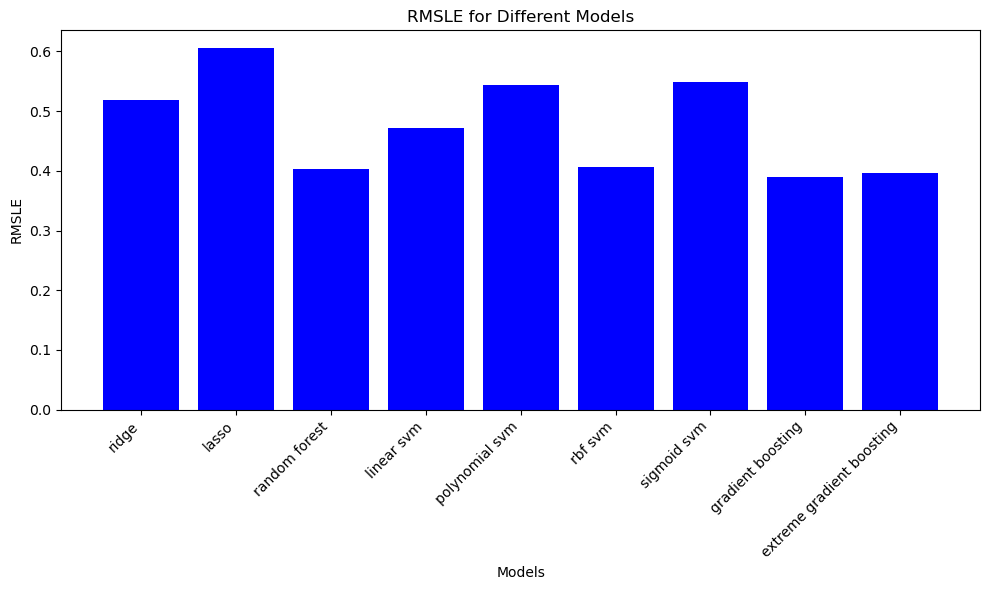

In [28]:
#We will plot the results of the models with its errors to see more clearly which are the best models

# Extract keys and values from the dictionary
models = list(trained_models.keys())
rmsle_values = [value[1] for value in trained_models.values()]

plt.figure(figsize=(10, 6))
plt.bar(models, rmsle_values, color='blue')
plt.xlabel('Models')
plt.ylabel('RMSLE')
plt.title('RMSLE for Different Models')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

As we can see, the ones with best performance during cross validation are ridge, lasso, gradient boosting and extreme gradient boosting, so we will perform stacking with these models.

To do staking we are going to follow the following steps:

In [40]:
#Step 1: Get the predictions of the best models 


# Get predictions using 5-fold cross-validation
xgb_model_pred = cross_val_predict(xgb_model, X_train, y_train, cv=5)

In [41]:
rbf_svr_model_pred = cross_val_predict(rbf_svr_model, X_train, y_train, cv=5)

In [42]:
gtb_model_pred = cross_val_predict(gtb_model, X_train, y_train, cv=5)

In [43]:
rf_model_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)

In [44]:
# Step 2: Stack the predictions

stacking_input = np.column_stack((xgb_model_pred, rbf_svr_model_pred, gtb_model_pred, rf_model_pred))

In [45]:
# Step 3: Define a meta-model for stacking (We tried all the best models to be the meta-model and we found that Ridge was the best)

param_grid = {'alpha': [10, 20, 50, 70, 90, 100]}

meta_model=GridSearchCV(Ridge(), param_grid, cv=5, scoring=rmsle_score, verbose=0)

In [46]:
# Step 4: Train the meta-model on the combined predictions

meta_model.fit(stacking_input, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [10, 20, 50, 70, 90, 100]},
             scoring=make_scorer(rmsle))

In [47]:
stacking_output= np.column_stack(( xgb_model.predict(X_test), ridge_model.predict(X_test), gtb_model.predict(X_test), lasso_model.predict(X_test)))

y_pred = meta_model.predict(stacking_output)

In [48]:
predictions(meta_model, stacking_input, y_train, dataset='Training')

Root Mean Squared Logarithmic Error on Training: 0.40758720092597206


0.40758720092597206

# Test set predictions

In [53]:
predictions(meta_model, stacking_output, y_test, dataset='Testing')

Root Mean Squared Logarithmic Error on Testing: 0.6006238430439558


0.6006238430439558

In [59]:
# Save the model to a file
with open('../models/meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)